# CAFEH Demo

Here we simulate some data and show how to use CAFEH to perform multi-trait fine-mapping and colocalization using individual level data or summary statistics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
from cafeh.cafeh_genotype import CAFEHGenotype
from cafeh.cafeh_summary import CAFEHSummary

from cafeh.misc import plot_components
from cafeh.fitting import weight_ard_active_fit_procedure
from cafeh.model_queries import *

def fit_cafeh_genotype(X, y, K=10, init_args={}, fit_args = {}):
    """
    Fit CAFEH using individual level genotype data
    LD: LD matrix
    X: [p, n] matrix of genotypes
    y: [t, n] matrix of observtions
    n: int or [t] number of samples in each phenotype,
        if not provided a large sample approximation is made
    """
    cafehg = CAFEHGenotype(X, y, K=10, p0k=0.1)
    weight_ard_active_fit_procedure(cafehg, verbose=False)
    return cafehg

def fit_cafeh_summary(LD, beta, stderr, n=np.inf, K=10, init_args={}, fit_args = {}):
    """
    Fit cafeh using reference LD, effect sizes, and standard errors
    
    LD: LD matrix
    beta: [t, p] matrix of effect sizes
    stderr: [t, p] matrix of standard error
    n: int or [t] number of samples in each phenotype,
        if not provided a large sample approximation is made
    """
    if not (type(n) == np.ndarray):
        n = np.ones(beta.shape[0]) * n
    S = np.sqrt(beta**2/n[:, None] + stderr**2)
    
    cafehs = CAFEHSummary(LD, B, S, K=K, **init_args)
    weight_ard_active_fit_procedure(cafehs, **fit_args)
    return cafehs


def fit_cafeh_z(LD, z, n=np.inf, K=10, init_args={}, fit_args={}):
    """
    Fit CAFEH using reference LD and zscores
    LD: LD matrix
    z: [t, p] matrix of z scores
    n: [t] number of samples in each phenotype,
        if not provided a large sample approximation is made
    """
    Z =  z / np.sqrt((z**2 + n[:, None]) / n[:, None])
    cafehz = CAFEHSummary(LD, Z, np.ones_like(z), K=K, **init_args)
    weight_ard_active_fit_procedure(cafehz, max_iter=100)
    return cafehz

### Simulate some data

First we simulate some data. We generate 3 phenotypes that all have a distinct causal variant, and a fourth causal variant shared across the 4

We generate multivariate normal "genotype" data where SNPs are correlated with their neighbors in an exponentially decaying manner.

In [37]:
t = 3  # number of phenotypes
n = 500  # number of samples
p = 1000  # number of features (SNPs)

# simulate some correlated features X
mix = np.exp(-np.abs(np.arange(p) - np.arange(p)[:, None])/50)
X = (np.random.normal(size=(n, p)) @ mix).T

# simulate phenotypes: each with a distinct causal variant and all with a shared causal variant
causal = np.zeros((t, p))
causal[0, [100, 500]] = 1
causal[1, [150, 500]] = 1
causal[2, [200, 500]] = 1

y = causal @ X + np.random.normal(size=(t, n)) * 3

### Compute summary statistics

Next we compute effect sizes and standard errors to use in the summary stat version of CAFEH

In [38]:
y_centered = y - y.mean(1)[:, None]
X_centered = X - X.mean(1)[:, None]

d = np.diag(X_centered @ X_centered.T)
B = (y_centered @ X_centered.T) / d[None]

sq_error = np.array([((y_centered[i][:, None] - X_centered.T * B[i])**2).sum(0) for i in range(t)])
stderr = np.sqrt(sq_error / (n-1) / d[None])
S = np.sqrt(B**2/n + stderr**2)
LD = np.corrcoef(X)

Text(0.5, 1.0, 'Simulation LD Matrix')

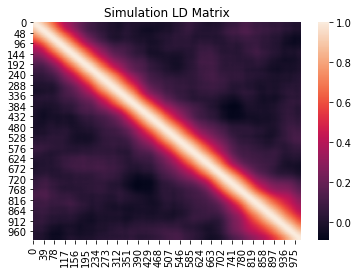

In [39]:
sns.heatmap(np.corrcoef(X))
plt.title('Simulation LD Matrix')

## Fitting CAFEH

We provide routines for fitting CAFEH using either individual level data or summary stats. We offer 3 routines, `fit_cafeh_genotype`, `fit_cafeh_summary` and `fit_cafeh_z` to make the process simple.

### Fit with `CAFEHGenotype`

The individual level version of CAFEH is implimented in `CAFEHGenotype`. `fit_cafeh_genotype` is a routine for initializing and fitting the model. `fit_cafeh_genotype` that accepts the following inputs

You will need
`X` an $p \times n$ genotype matrix
`Y` a $t \times n$ phenotype matrix
`cov` (optional) DataFrame of covariatiats.
`init_args` (optional) a dictionary of arguments to pass to the `CAFEHGenotype` initializer.
`fit_args` (optional) a dictionary of arguments to pass to the `weight_ard_active_fit_procedure`


**A note on covariates** 

Please note that if you are using covariates the covariates should be formatted as a `pandas.DataFrame` with a 2-level index `[study_id, covariate_name]` and column names that correspond with `sample_ids`. This is necessary because not all phenotypes need by observed in all individuals, so the model needs to know which covariates are relevant to each sample.


**A note on `weight_ard_active_fit_procedure`** 

By default we fit the model using the `weight_ard_active_fit_procedure`, which we find helpful for avoiding local optima in model fitting, especially in the absence of a good initialization. We fit the model in 3 stages.
1. Fit the weights holding estimating prior variance and assignments fixed
2. Fit the weights + weight variances holding assignments fixed
3. Fit all parameters in the model

In [45]:
%%time
cafehg = fit_cafeh_genotype(X, y, K=10)

CPU times: user 1.88 s, sys: 55.2 ms, total: 1.94 s
Wall time: 494 ms


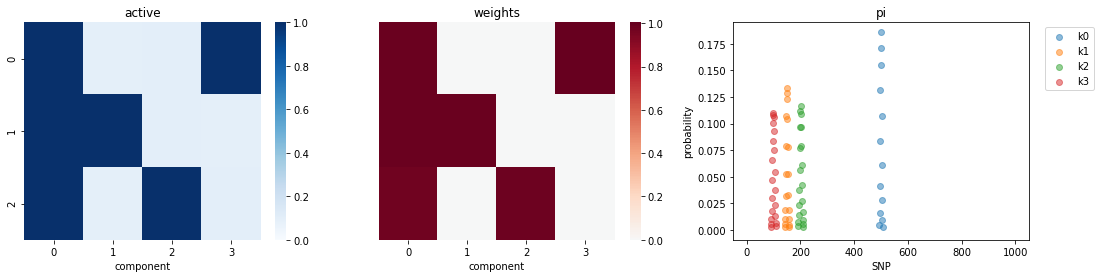

In [46]:
# plot
cafehg.plot_components()

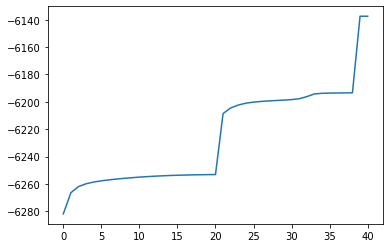

In [53]:
# check ELBO is monotonically increasing
# note that 3 "bumps" are the 3 different stages of model fitting
plt.plot(cafehg.elbos)

In [47]:
# Get 95% Credible sets for each component
credible_sets = cafehg.get_credible_sets(0.95)
credible_sets[0], credible_sets[1], credible_sets[2], credible_sets[3]

(array([500, 499, 501, 498, 502, 497, 503, 496, 504]),
 array([150, 149, 151, 148, 152, 147, 153, 154, 146, 155, 145, 156, 144]),
 array([201, 200, 202, 199, 203, 204, 198, 205, 197, 206, 196, 207, 195,
        208]),
 array([100,  99, 101,  98, 102,  97, 103,  96, 104,  95, 105,  94, 106,
         93]))

In [48]:
# summarize results in a table
variant_report = summary_table(cafehg, True, max_snps=500, min_p_active=0.5)
variant_report.sort_values('alpha').head(n=6)

,variant_id,study,pip,top_component,alpha,rank,p_active,pi,effect,effect_var
2500,500,2,0.186404,0,0.000000,0,1.0,0.185928,0.978755,0.004326
2201,201,2,0.116956,2,0.000000,0,1.0,0.116438,0.986536,0.004113
500,500,0,0.186405,0,0.000000,0,1.0,0.185928,0.994596,0.004432
1150,150,1,0.133694,1,0.000000,0,1.0,0.133190,0.999182,0.004189
1500,500,1,0.186401,0,0.000000,0,1.0,0.185928,0.989172,0.004371
101,101,0,0.106665,3,0.218294,2,1.0,0.106141,1.005054,0.004452


### Fit CAFEH with summary stats

The summary stat version of CAFEH is implimented in `CAFEHSummary`.

If you have effect sizes and standard error you can use `fit_cafeh_summary`.
If you have z-scores you can use `fit_cafeh_z`. 

Please note that with `fit_cafeh_z`, the scale of the weights may not be comparable across multiple phenotypes, especially if there were a different number of samples in each phenotype, since z-scores conflate effect size and significance.

Implementation of `CAFEHSummary` is based off of the Regression form Summary Statistics (RSS) likelihood of Zhu and Stephens [1]. We impliment a stochastic optimization routine which. At each iteration we sample an active SNP for each component according the to current posterior estimates `pi`.

### Fit with betas and standard errors

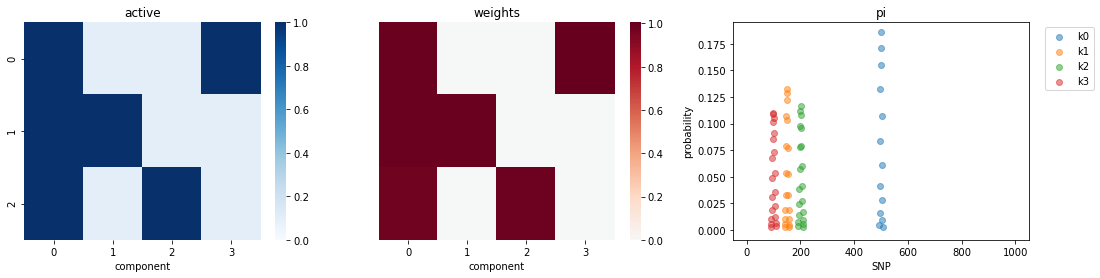

CPU times: user 5.36 s, sys: 96.5 ms, total: 5.46 s
Wall time: 1.64 s


In [63]:
%%time
cafehs = fit_cafeh_summary(LD, B, stderr, n=n)
cafehs.plot_components()

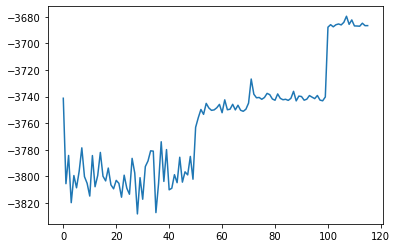

In [64]:
plt.plot(cafehs.elbos)

In [65]:
%%time
cafehs = fit_cafeh_z(LD, B/stderr, n=np.ones(3)*n)

CPU times: user 6.6 s, sys: 33.8 ms, total: 6.63 s
Wall time: 1.66 s


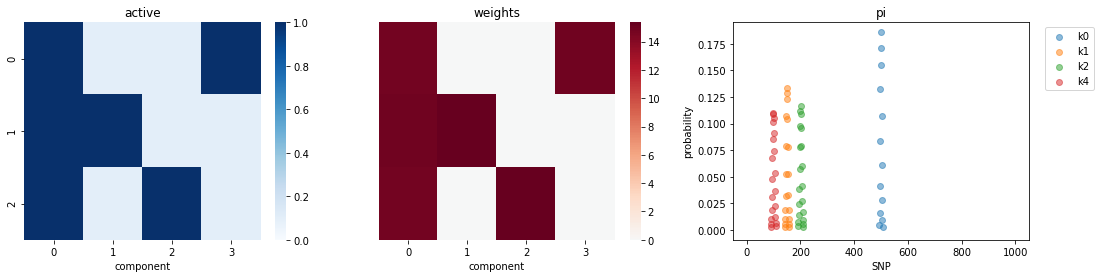

In [66]:
cafehs.plot_components()

### References 

1. Zhu, X., & Stephens, M. (2017). Bayesian large-scale multiple regression with summary statistics from genome-wide association studies. The annals of applied statistics, 11(3), 1561.
